# Análisis de sentimientos de sitios web

José Antonio Garcia Antona

usaremos los pipelines de transfromer:

<https://huggingface.co/docs/transformers/main_classes/pipelines>

In [2]:
# Instalación de librerías necesarias
# Si aún no tienes las librerías instaladas
#!pip install requests beautifulsoup4 transformers matplotlib seaborn
from transformers import pipeline

# Importación de librerías
from bs4 import BeautifulSoup
import requests
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
# Crea una instancia del clasificador de texto
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
classifier = pipeline("sentiment-analysis", model=model_name)
# 1 estrella negativo
# 5 estrellas positivo

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [4]:
# Función para obtener titulares de un periódico
def get_headlines(url):
    """
    Obtiene titulares de la página principal del periódico extraído de la URL.

    Args:
        url (str): URL de la página principal del periódico.

    Returns:
        list: Lista de titulares extraídos.
    """

    # Diccionario con selectores CSS específicos para cada periódico
    selectors = {
        "elpais": ".c_t a",  # Selector actualizado para El País
        "abc": "h2 a",
        "bbc": "h2"
    }

    # Intentar extraer el nombre base del dominio
    try:
        newspaper = re.search(r"https?://(?:www\.)?([a-z]+)", url).group(1)
    except AttributeError:
        raise ValueError("No se pudo extraer el nombre del periódico de la URL.")

    if newspaper not in selectors:
        raise ValueError(f"Periódico '{newspaper}' no soportado. Usa uno de {list(selectors.keys())}.")

    # Encabezados para simular un navegador
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
    }

    # Realizar la solicitud HTTP
    try:
        response = requests.get(url, headers=headers)  # Añadimos headers aquí
        response.raise_for_status()  # Asegurarse de que la respuesta sea exitosa
    except requests.exceptions.RequestException as e:
        raise RuntimeError(f"Error al acceder a la URL: {e}")

    # Analizar el HTML
    soup = BeautifulSoup(response.content, 'html.parser')
    selector = selectors[newspaper]
    headlines = [h.text.strip() for h in soup.select(selector)]

    if not headlines:
        raise RuntimeError("No se encontraron titulares. Verifica el selector CSS.")

    return headlines[:100]  # Limitar a los primeros 10 titulares

In [5]:
# Análisis de sentimientos
def analyze_sentiments(headlines):
    results = []
    for headline in headlines:
        sentiment = classifier(headline)[0]
        results.append({
            'headline': headline,
            'label': sentiment['label'],
            'score': sentiment['score']
        })
    return results

In [6]:
# Visualización de resultados
def visualize_results(results):
    # Conteo de etiquetas
    labels = [r['label'] for r in results]
    sns.countplot(x=labels, palette="viridis")
    plt.title("Distribución de Sentimientos")
    plt.xlabel("Sentimientos")
    plt.ylabel("Cantidad")
    plt.show()

    # Mostrar titulares más positivos y negativos
    sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)
    print("\n*** Titular más positivo ***")
    print(f"{sorted_results[0]['headline']} (Score: {sorted_results[0]['score']:.2f})")

    print("\n*** Titular más negativo ***")
    negative_results = [r for r in sorted_results if r['label'] == 'NEGATIVE']
    if negative_results:
        print(f"{negative_results[0]['headline']} (Score: {negative_results[0]['score']:.2f})")
    else:
        print("No hay titulares negativos en este análisis.")



In [20]:
# El pais
url = "https://elpais.com/"
headlines = get_headlines(url)
print("Titulares de El País:")
print(headlines)

Titulares de El País:
['En Texas ya comenzó el mandato de Donald Trump', 'California se prepara para el impacto de la segunda presidencia de Trump', 'Biden recibe duras críticas desde el propio Partido Demócrata por el indulto a su hijo Hunter', 'Consumo, pago de impuestos y empleo: los argumentos de Sheinbaum contra el discurso antimigrante de Trump', 'Maduro ofrece a Trump su “experiencia” en seguridad para combatir la criminalidad', '“Le dieron golpes y me lo mataron”: la muerte de un preso político en una cárcel cubana', 'Art Basel 2024: una nueva era de inclusión y diversidad bajo el liderazgo de Bridget Finn', 'Trump anuncia que acudirá a la reapertura de Notre Dame este sábado en París', 'El republicano\xa0asegura que vetará la compra de US Steel por parte de la japonesa Nippon Steel', 'El chavismo intensifica el acoso contra María Corina Machado con una estricta vigilancia a su madre', 'Milei deja a Argentina sin políticas estatales de control de natalidad y de salud sexual', '

In [21]:
results = classifier(headlines)

# Imprimir los resultados
for headline, result in zip(headlines, results):
    print(f"Texto: {headline}\nSentimiento: {result['label']} (Puntaje: {result['score']:.4f})\n")


Texto: En Texas ya comenzó el mandato de Donald Trump
Sentimiento: 5 stars (Puntaje: 0.2122)

Texto: California se prepara para el impacto de la segunda presidencia de Trump
Sentimiento: 4 stars (Puntaje: 0.4496)

Texto: Biden recibe duras críticas desde el propio Partido Demócrata por el indulto a su hijo Hunter
Sentimiento: 2 stars (Puntaje: 0.2996)

Texto: Consumo, pago de impuestos y empleo: los argumentos de Sheinbaum contra el discurso antimigrante de Trump
Sentimiento: 1 star (Puntaje: 0.2459)

Texto: Maduro ofrece a Trump su “experiencia” en seguridad para combatir la criminalidad
Sentimiento: 5 stars (Puntaje: 0.6048)

Texto: “Le dieron golpes y me lo mataron”: la muerte de un preso político en una cárcel cubana
Sentimiento: 1 star (Puntaje: 0.4071)

Texto: Art Basel 2024: una nueva era de inclusión y diversidad bajo el liderazgo de Bridget Finn
Sentimiento: 5 stars (Puntaje: 0.5246)

Texto: Trump anuncia que acudirá a la reapertura de Notre Dame este sábado en París
Sentimien

<ipython-input-22-550019217f7f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=stars, palette="viridis")


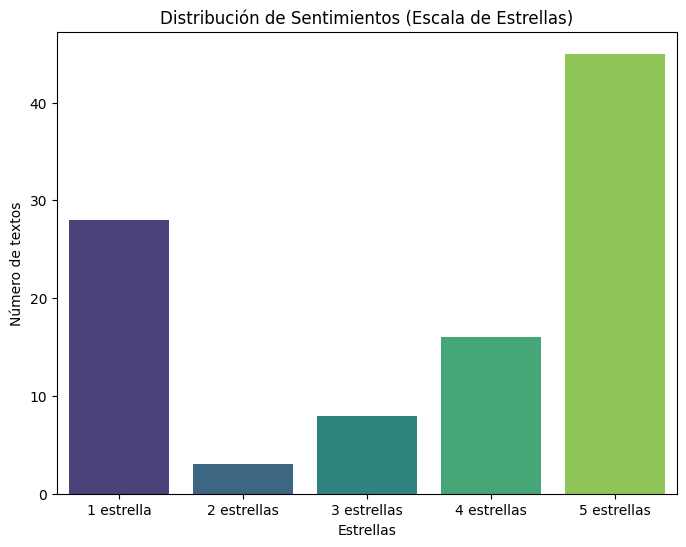

In [22]:
# Extraer las etiquetas de estrellas (1-5)
labels = [result['label'] for result in results]
# Convertir las etiquetas de 'X star' a enteros (1-5)
stars = [int(label.split()[0]) for label in labels]

# Extraer las etiquetas de estrellas (1-5)
labels = [result['label'] for result in results]
# Convertir las etiquetas de 'X star' a enteros (1-5)
stars = [int(label.split()[0]) for label in labels]

# Gráfico de barras
plt.figure(figsize=(8, 6))
sns.countplot(x=stars, palette="viridis")

# Agregar título y etiquetas
plt.title("Distribución de Sentimientos (Escala de Estrellas)")
plt.xlabel("Estrellas")
plt.ylabel("Número de textos")
plt.xticks([0, 1, 2, 3, 4], ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"])

# Mostrar el gráfico de barras
plt.show()

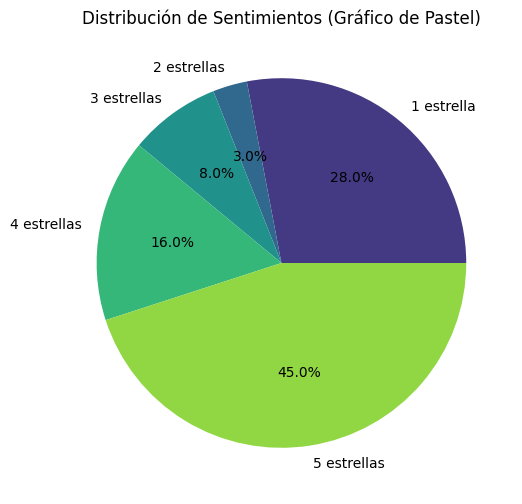

In [23]:
# Gráfico de pastel
plt.figure(figsize=(8, 6))
labels_pie = ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
sizes = [stars.count(i + 1) for i in range(5)]
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=sns.color_palette("viridis", 5))

# Agregar título
plt.title("Distribución de Sentimientos (Gráfico de Pastel)")

# Mostrar el gráfico de pastel
plt.show()

In [24]:
# ABC
url = "https://www.abc.es/"
headlines = get_headlines(url)
print("Titulares de ABC:")
print(headlines)

Titulares de ABC:
['Ribera intentó apropiarse de la Comisión Nacional de la Energía antes de irse a Bruselas', 'Ferraz confirma el desembarco de Óscar López en Madrid y no renuncia a sustituir a Espadas y Tudanca', 'Todos los señalados por Pedro Sánchez en el Congreso Federal del PSOE', 'El Gobierno deberá aclarar qué papel tuvo el CNI en la casa que iba a acoger a Delcy', 'La UCE de la Guardia Civil aplicó un protocolo interno para pillar al comandante imputado en el caso Koldo', 'Biden hunde a los demócratas con un indulto sin precedentes', 'El Congreso fiscalizará a tres de las adjudicatarias de lenguas cooficiales por ofertas muy bajas', 'El revés del PP al concierto catalán en el Senado desvela discrepancias de fondo entre PSOE y ERC', 'Dos mociones de censura contra el primer ministro hacen tambalear al Gobierno francés', 'Page cree que el caso Koldo y Ábalos «tiene muchas ramificaciones» y es «una bomba de racimo»: «A mí me preocupa»', 'Bildu divide a las víctimas del terrorismo

In [25]:
results = classifier(headlines)

# Imprimir los resultados
for headline, result in zip(headlines, results):
    print(f"Texto: {headline}\nSentimiento: {result['label']} (Puntaje: {result['score']:.4f})\n")


Texto: Ribera intentó apropiarse de la Comisión Nacional de la Energía antes de irse a Bruselas
Sentimiento: 1 star (Puntaje: 0.3753)

Texto: Ferraz confirma el desembarco de Óscar López en Madrid y no renuncia a sustituir a Espadas y Tudanca
Sentimiento: 4 stars (Puntaje: 0.2995)

Texto: Todos los señalados por Pedro Sánchez en el Congreso Federal del PSOE
Sentimiento: 5 stars (Puntaje: 0.4634)

Texto: El Gobierno deberá aclarar qué papel tuvo el CNI en la casa que iba a acoger a Delcy
Sentimiento: 3 stars (Puntaje: 0.2831)

Texto: La UCE de la Guardia Civil aplicó un protocolo interno para pillar al comandante imputado en el caso Koldo
Sentimiento: 1 star (Puntaje: 0.2830)

Texto: Biden hunde a los demócratas con un indulto sin precedentes
Sentimiento: 1 star (Puntaje: 0.5297)

Texto: El Congreso fiscalizará a tres de las adjudicatarias de lenguas cooficiales por ofertas muy bajas
Sentimiento: 1 star (Puntaje: 0.5649)

Texto: El revés del PP al concierto catalán en el Senado desvela 

<ipython-input-26-550019217f7f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=stars, palette="viridis")


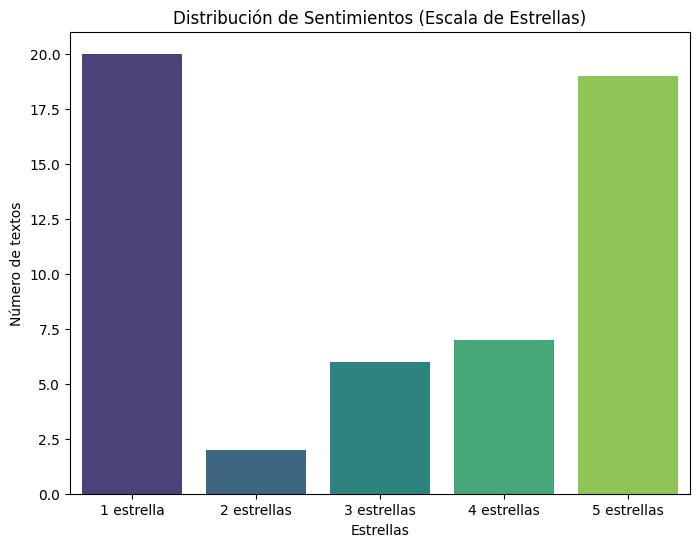

In [26]:
# Extraer las etiquetas de estrellas (1-5)
labels = [result['label'] for result in results]
# Convertir las etiquetas de 'X star' a enteros (1-5)
stars = [int(label.split()[0]) for label in labels]

# Extraer las etiquetas de estrellas (1-5)
labels = [result['label'] for result in results]
# Convertir las etiquetas de 'X star' a enteros (1-5)
stars = [int(label.split()[0]) for label in labels]

# Gráfico de barras
plt.figure(figsize=(8, 6))
sns.countplot(x=stars, palette="viridis")

# Agregar título y etiquetas
plt.title("Distribución de Sentimientos (Escala de Estrellas)")
plt.xlabel("Estrellas")
plt.ylabel("Número de textos")
plt.xticks([0, 1, 2, 3, 4], ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"])

# Mostrar el gráfico de barras
plt.show()

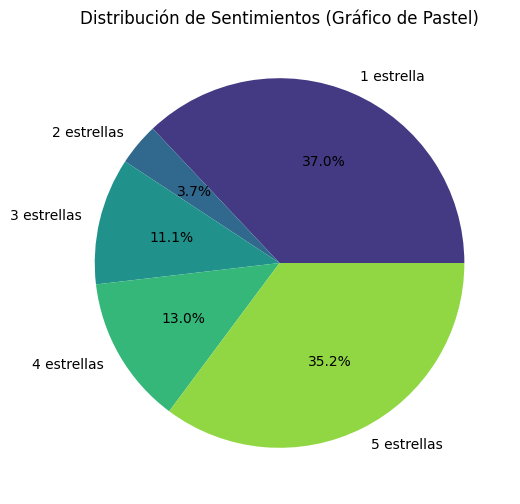

In [27]:
# Gráfico de pastel
plt.figure(figsize=(8, 6))
labels_pie = ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
sizes = [stars.count(i + 1) for i in range(5)]
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=sns.color_palette("viridis", 5))

# Agregar título
plt.title("Distribución de Sentimientos (Gráfico de Pastel)")

# Mostrar el gráfico de pastel
plt.show()

In [28]:
# BBC
url = "https://www.bbc.com"
headlines = get_headlines(url)
print("Titulares de BBC:")
print(headlines)

Titulares de BBC:
["Musk's record $56bn pay deal rejected for second time", 'Gazans displaced by war now face a new threat: winter', "Musk's record $56bn pay deal rejected for second time", 'Gazans displaced by war now face a new threat: winter', "Vietnamese tycoon loses death row appeal over world's biggest bank fraud", "Jaguar's new electric concept car divides opinion", 'Ukraine’s exhausted troops in Russia told to cling on and wait for Trump', "Femicide victim's family awaits killer's sentence, and change in Italy", "Nosferatu has 'so much to sink your teeth into' ★★★★☆", 'Only from the BBC', "Albania's one-of-a-kind wild kayaking adventure", 'How to avoid being a toxic friend', 'More news', 'Australian suspect in 1977 murders extradited from Italy', "In pictures: 40 years since world's deadliest gas leak killed thousands in India", 'Top Indian fact-checker in court for post calling out hate speech', 'White House defends pardon of Hunter Biden amid backlash', 'Starmer: UK does not 

In [29]:
results = classifier(headlines)

# Imprimir los resultados
for headline, result in zip(headlines, results):
    print(f"Texto: {headline}\nSentimiento: {result['label']} (Puntaje: {result['score']:.4f})\n")


Texto: Musk's record $56bn pay deal rejected for second time
Sentimiento: 1 star (Puntaje: 0.6143)

Texto: Gazans displaced by war now face a new threat: winter
Sentimiento: 4 stars (Puntaje: 0.2494)

Texto: Musk's record $56bn pay deal rejected for second time
Sentimiento: 1 star (Puntaje: 0.6143)

Texto: Gazans displaced by war now face a new threat: winter
Sentimiento: 4 stars (Puntaje: 0.2494)

Texto: Vietnamese tycoon loses death row appeal over world's biggest bank fraud
Sentimiento: 1 star (Puntaje: 0.8457)

Texto: Jaguar's new electric concept car divides opinion
Sentimiento: 4 stars (Puntaje: 0.3625)

Texto: Ukraine’s exhausted troops in Russia told to cling on and wait for Trump
Sentimiento: 1 star (Puntaje: 0.5021)

Texto: Femicide victim's family awaits killer's sentence, and change in Italy
Sentimiento: 4 stars (Puntaje: 0.2418)

Texto: Nosferatu has 'so much to sink your teeth into' ★★★★☆
Sentimiento: 5 stars (Puntaje: 0.6999)

Texto: Only from the BBC
Sentimiento: 1 star

<ipython-input-30-eb8769c4d893>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=stars, palette="viridis")


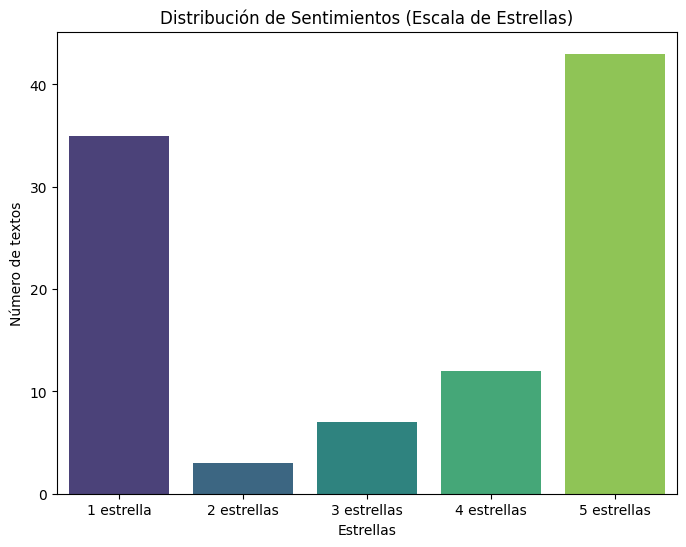

In [30]:
# Extraer las etiquetas de estrellas (1-5)
labels = [result['label'] for result in results]
# Convertir las etiquetas de 'X star' a enteros (1-5)
stars = [int(label.split()[0]) for label in labels]

# Gráfico de barras
plt.figure(figsize=(8, 6))
sns.countplot(x=stars, palette="viridis")

# Agregar título y etiquetas
plt.title("Distribución de Sentimientos (Escala de Estrellas)")
plt.xlabel("Estrellas")
plt.ylabel("Número de textos")
plt.xticks([0, 1, 2, 3, 4], ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"])

# Mostrar el gráfico de barras
plt.show()

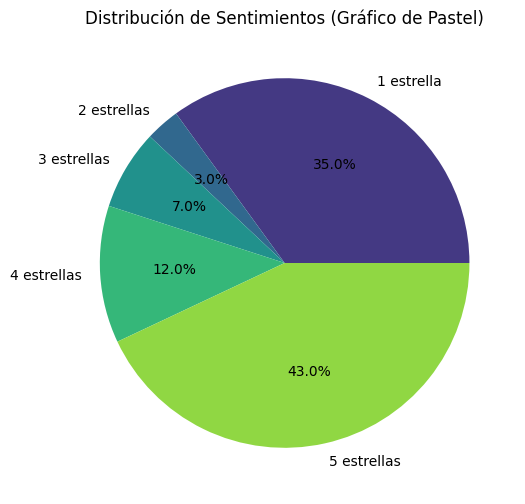

In [31]:
# Gráfico de pastel
plt.figure(figsize=(8, 6))
labels_pie = ["1 estrella", "2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
sizes = [stars.count(i + 1) for i in range(5)]
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=sns.color_palette("viridis", 5))

# Agregar título
plt.title("Distribución de Sentimientos (Gráfico de Pastel)")

# Mostrar el gráfico de pastel
plt.show()